<a href="https://colab.research.google.com/github/AllanKamimura/Pai_ta_ON_python/blob/main/school/SAA0184_static_stability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme("poster")

# Base Class

In [ ]:
class LiftSurface:
    def __init__(self):
        self.CM0         = 0
        self.b           = np.sqrt(self.AR * self.S)
        self.cma         = self.compute_mean_aerodynamic_chord()

### compute_CL (LiftSurface)
---

given an angle of attack α, returns the Lift Coefficient of the Lift Surface

<br>
<center>
$
C_L = a_{surface} ⋅ (α + i_{surface} - \alpha_{L0} - ϵ)
$
</center>
<br>

Variable      | name
--------------|----
$C_L        $ | Lift Surface's Lift coefficient 
$a_{surface}$ | Lift Surface's Line Angular coefficient
$α          $ | Aircraft's Angle of Attack 
$i_{surface}$ | Lift Surface's Angle of Incidence 
$\alpha_{L0}$ | Lift Surface's Zero Lift Angle
$ϵ          $ | Lift Surface's Angle of Downwash

In [ ]:
def compute_CL(self, alpha, epsilon = 0):
    i         = self.alpha
    alpha_L0  = self.alpha_L0
    a         = self.cl_alpha

    CL = a * (alpha + i - alpha_L0 - epsilon)

    self.CL = CL

    return CL
    
LiftSurface.compute_CL = compute_CL

### compute_mean_aerodynamic_chord
---
given the wing's geometric features, returns the mean aerodynamic chord for a trapezoidal wing

<br>
<center>
$
C_R = \frac{2}{(1 + λ)} \cdot \frac{S_w}{b_w}
$
</center>
<br>
<center>
$
c̄ = \frac{2}{3} \cdot C_R \cdot \frac{1 + λ + λ^2}{1+λ}
$
</center>
<br>

Variable      | name
--------------|----
$C_R        $ | Wing's Root Chord 
$S_w        $ | Wing's Area
$b_w        $ | Wing's Span
$λ          $ | Wing's Taper Ratio
$c̄          $ | Wing's Mean Aerodynamic Chord

In [ ]:
def compute_mean_aerodynamic_chord(self):
    S_w     = self.S
    bw      = self.b
    lambda_ = self.taper_ratio
    
    cr  = 2 / (1 + lambda_) * (S_w / bw)
    cma = 2/3 * cr * (1 + lambda_ + lambda_ ** 2) / (1 + lambda_)
    
    self.cma = cma

    return cma

LiftSurface.compute_mean_aerodynamic_chord = compute_mean_aerodynamic_chord

### compute_rotation_radius
---
given the point at which a force is applied, returns the moment arm with respect to the aircraft's center of gravity (CG)

<br>
<center>
$
r = x - x_{CG}
$
</center>
<br>

the following approximations are used:

<br>
<center>
$
α ≈ 0 ⇒ 
\begin{cases} 
    sin(α) ≈ α ≈ 0 \\
    cos(α) ≈ 1  
\end{cases}
$
<br><br>
$
D ≪ L ⇒ 
\begin{cases} 
    Z = - L ⋅ cos(α) - D ⋅ sin(α)  ≈ -L \\
    X = - L ⋅ sin(α) + D ⋅ cos(α)  ≈ 0 
\end{cases}
$
</center>
<br>

Thus, the rotation radius is computed on the x-axis alone

<br>

Variable      | name
--------------|----
$x          $ | x-axis position of force application
$x_{CG}     $ | x-axis position of CG
$α          $ | Angle of Attack
$L          $ | Lift Force
$D          $ | Drag Force
$X          $ | Net Force in the x direction
$Z          $ | Net Force in the z direction

In [ ]:
def compute_rotation_radius(self, position):
    xcg, zcg = self.CG
    x  , z   = position

    r = (x - xcg)

    self.r = r

    return r

LiftSurface.compute_rotation_radius = compute_rotation_radius

### compute_CM (LiftSurface)
---

given an angle of attack α and the CG position, returns the Pitching Moment Coefficient of the Lift Surface

<br>
<center>
$
C_M = C_{M0} + C_L ⋅ \frac{r}{c}
$
</center>
<br>

Variable      | name
--------------|----
$C_M        $ | Lift Surface's Pitching Moment coefficient 
$C_{M0}     $ | Lift Surface's Pitching Moment zero-lift 
$C_L        $ | Lift Surface's Lift coefficient
$r          $ | Rotation Radius 
$c          $ | Wing's Mean Aerodynamic Chord

In [ ]:
def compute_CM(self, alpha, position, c = 1):
    CL  = self.CL
    CM0 = self.CM0

    r = self.compute_rotation_radius(position)
    CM = CM0 + CL * (r / c)

    self.CM  = CM

    return CM
    
LiftSurface.compute_CM = compute_CM

# Aircraft Class

In [ ]:
class Aircraft:
    def __init__(self):
        self.wing    = Wing()
        self.tail    = Tail_h()
        self.flycond = FlyCond()

        self.alpha  = np.linspace(-10, 10, 30)
        self.CG     = [7.89, 0] # (x, z)
        self.mass   = 5400
        self.eta    = 0.89
        self.CM0    = 0

### compute_downwash
---

given an angle of attack α, computes the downwash angle (effect caused by the wing on the horizontal tail), using the datcom approximation

<br>
<center>
$
{\Large
k_h = \frac{1 - \frac{z_t-z_w}{b}} {(2⋅\frac{x_t-x_w}{b})^{\frac{1}{3}}}
}
$
</center>
<br>
<center>
$
k_λ = \frac{10 - 3 ⋅ λ_w}{7}
$
</center>
<br>
<center>
$
k_{AR} = \frac{1}{AR_w} - \frac{1}{1 + AR_w^{1.7}}
$
</center>
<br>

---

<br>
<center>
$
\frac{dε}{dα} = 4.44 ⋅ (k_h ⋅ k_λ ⋅ k_{AR} ⋅ \sqrt{cosΛ})^{1.19}
$
</center>
<br>
<center>
$
ε_0 = - \frac{dε}{dα} ⋅ (α_{L0} - α)
$
</center>
<br>
<center>
$
ε = ε_0 + \frac{dε}{dα} ⋅ α
$
</center>
<br>

Variable             | name
---------------------|----
$x_t\text{ and }z_t$ | Tail's CG position
$x_w\text{ and }z_w$ | Wing's CG position
$b                 $ | Wing's Span
$λ                 $ | Wing's Taper Ratio 
$Λ                 $ | Wing's Sweep Angle
$α                 $ | Aircraft's Angle of Attack
$α_{L0}            $ | Aircraft's zero Lift Angle
$ε                 $ | Angle of Downwash


In [ ]:
def compute_downwash(self, alpha):
    xw, zw   = self.wing.CG
    xt, zt   = self.tail.CG

    bw       = self.wing.b
    AR       = self.wing.AR
    lambda_  = self.wing.taper_ratio
    LAMBDA   = self.wing.sweep_angle
    alpha_L0 = self.wing.alpha_L0
    alpha    = self.wing.alpha

    Kh = (1 - (zt - zw) / bw) / (2*(xt - xw) / bw) ** (1/3)
    Kl = (10 - 3 * lambda_) / 7
    KA = 1 / AR - 1 / (1 + AR ** 1.7)
    deda = 4.44 * (Kh * Kl * KA * np.sqrt(np.cos(LAMBDA))) ** (1.19)

    alpha_aux = (alpha_L0 - alpha)
    epsilon0  = - deda * alpha_aux

    print(
        "Downwash: \n\teps0 = {:.4f} \n\tdeda = {:.4f}".format(
            epsilon0, deda)
        )

    return epsilon0, deda

Aircraft.compute_downwash = compute_downwash

### compute_CL (Aircraft)
---

given an angle of attack α, returns the Lift Coefficient of the aircraft

<br>
<center>
$
C_L = C_{L_w} + C_{L_t} ⋅ η ⋅ \frac{S_t}{S_w}
$
</center>
<br>

Variable      | name
--------------|----
$C_L        $ | Aircraft's Lift coefficient 
$C_{L_w}    $ | Wing's Lift coefficient 
$C_{L_t}    $ | Tail's Lift coefficient 
$η          $ | $\frac{U_t^2}{U_w^2}$
$S_w        $ | Wing's Area
$S_t        $ | Tail's Area 
$α          $ | Aircraft's Angle of Attack 

In [ ]:
def compute_CL(self, alpha):
    S_w = self.wing.S
    S_t = self.tail.S
    eta = self.eta

    epsilon0, deda = self.compute_downwash(alpha)
    epsilon = epsilon0 + deda * alpha

    CL_w = self.wing.compute_CL(alpha)
    CL_t = self.tail.compute_CL(alpha, epsilon)
    CL = CL_w + CL_t * (S_t / S_w) * eta 

    self.deda     = deda
    self.epsilon0 = epsilon0

    self.CL       = CL
    self.CL_alpha, self.CL0 = np.polyfit(alpha, CL, 1)

    print(
        "CL: \n\tCL       = CL_alpha * alpha + CL0 \n\tCL_alpha = {:.4f} \n\tCL0      = {:.4f}".format(
            self.CL_alpha, self.CL0)
        )
    
    return CL

Aircraft.compute_CL = compute_CL

### compute_CM (Aircraft)
---

given an angle of attack α, returns the Pitching Moment Coefficient of the aircraft

<br>
<center>
$
C_M = C_{M_0} + C_{M_w} + C_{M_t} ⋅ η ⋅ \frac{S_t}{S_w}
$
</center>
<br>

Variable      | name
--------------|----
$C_M        $ | Aircraft's Pitching Moment coefficient 
$C_{M_0}    $ | Aircraft's Pitching Moment zero-lift  
$C_{M_w}    $ | Wing's Pitching Moment coefficient 
$C_{M_t}    $ | Tail's Pitching Moment coefficient 
$η          $ | $\frac{U_t^2}{U_w^2}$
$S_w        $ | Wing's Area
$S_t        $ | Tail's Area 
$α          $ | Aircraft's Angle of Attack 

In [ ]:
def compute_CM(self, alpha, position = None):
    S_t      = self.tail.S
    S_w      = self.wing.S
    cma      = self.wing.cma 
    eta      = self.eta
    CM0      = self.CM0

    if position == None:
        position = self.CG

    CM_w = self.wing.compute_CM(alpha, position, cma)
    CM_t = self.tail.compute_CM(alpha, position, cma)

    CM = CM0 + CM_w + CM_t * (S_t / S_w) * eta

    self.CM = CM
    self.CM_alpha, self.CM0 = np.polyfit(alpha, CM, 1)

    print(
        "CM: \n\tCM       = CM_alpha * alpha + CM0 \n\tCM_alpha = {:.4f} \n\tCM0      = {:.4f}".format(
            self.CM_alpha, self.CM0)
        )
    
    return CM

Aircraft.compute_CM = compute_CM

### compute_xcp (Aircraft)
---

return the aircraft's center of pressure

<br>
<center>
$
x_{cp} = \frac{x_{cg}}{c̄} - \frac{C_M}{C_L}
$
</center>
<br>

Variable      | name
--------------|----
$x_{cp}      $ | Aircraft's center of pressure
$x_{cg}      $ | Aircraft's CG 
$c̄           $ | Wing's Mean Aerodynamic Chord
$C_M         $ | Aircraft's Pitching Moment Coefficient 
$C_L         $ | Aircraft's Lift Coefficient

In [ ]:
def compute_xcp(self):
    cma      = self.wing.cma 
    xcg, zcg = self.CG
    CL       = self.CL
    CM       = self.CM

    xcp = (xcg / cma) - (CM / CL)

    self.xcp = xcp

    return xcp

Aircraft.compute_xcp = compute_xcp

### compute_CL (Aircraft)
---

returns the Lift Coefficient of the trimmed aircraft ($C_M = 0$)
<br>
<center>
$
C_{M} = C_{M_0} + C_{M_α} ⋅ α = 0 ⇒ α_{trim} = - \frac{C_{M_0}}{C_{M_α}}
$
</center>
<br>
<center>
$
C_{L_{trim}} = C_{L_0} + C_{M_α} ⋅ α_{trim}
$
</center>
<br>

Variable      | name
--------------|----
$α_{trim}    $ | Aircraft's trimmed angle 
$C_{M_0}      $ | Aircraft's Pitching Moment Coefficient zero-lift
$C_{M_α}      $ | Aircraft's Pitching Moment Coefficient Line Angular
$C_{L_0}      $ | Aircraft's Lift Coefficient zero-lift
$C_{L_α}      $ | Aircraft's Lift Coefficient Angle Line Angular
$C_{L_{trim}}$ | Aircraft's Trimmed Lift Coefficient

In [ ]:
def compute_cl_trim(self):
    CM_alpha, CM0 = self.CM_alpha, self.CM0
    CL_alpha, CL0 = self.CL_alpha, self.CL0

    alpha_trim = - CM0 / CM_alpha
    CL_trim    = + CL0 + CM_alpha * alpha_trim

    self.alpha_trim = alpha_trim
    self.CL_trim    = CL_trim

    print(
        "Trimagem: \n\talpha_trim = {:.4f} \n\tCL_trim    = {:.4f}".format(
            alpha_trim, CL_trim
        ))       

    return CL_trim

Aircraft.compute_cl_trim = compute_cl_trim

### compute_xn (Aircraft)
---

returns the neutral point of the aircraft
<br>
<center>
$
MS = - \frac{C_{M_α}}{C_{L_α}}
$
</center>
<br>
<center>
$
x_N = x_{CG} + c̄ ⋅ (- MS)
$
</center>
<br>

Variable       | name
---------------|----
$MS          $ | Aircraft's Static Margin
$C_{M_α}     $ | Aircraft's Pitching Moment Coefficient Line Angular
$C_{L_α}     $ | Aircraft's Lift Coefficient Line Angular
$x_{CG}      $ | Aircraft's CG
$c̄           $ | Wing's Mean Aerodynamic Chord
$x_N         $ | Aircraft's neutral point

In [ ]:
def compute_xn(self):
    CM_alpha = self.CM_alpha
    CL_alpha = self.CL_alpha
    xcg, zcg = self.CG
    cma      = self.wing.cma

    MS = - CM_alpha / CL_alpha
    xn = xcg + cma * (- MS)

    self.xn = xn
    self.MS = MS

    print(
        "x_n: \n\tx_n = {:.4f} \n\tMS  = {:.4f}".format(
            xn, MS
        ))
    
    return xn

Aircraft.compute_xn = compute_xn

# Main

In [ ]:
class Wing(LiftSurface):
    def __init__(self):
        self.S           = 34
        self.taper_ratio = 0.48
        self.AR          = 9.74
        self.CG          = [7.5, -0.88] # (x, z)
        self.sweep_angle = 0
        self.cl_alpha    = 5.4
        self.alpha_L0    = -3 / 180 * np.pi
        self.alpha       =  1 / 180 * np.pi

        super().__init__()


class Tail_h(LiftSurface):
    def __init__(self):
        self.S           = 6.48
        self.taper_ratio = 0.3048
        self.AR          = 6.22
        self.CG          = [13.8, 2.68] # (x, z)
        self.sweep_angle = 0
        self.cl_alpha    = 5.1
        self.alpha_L0    = 0 / 180 * np.pi
        self.alpha       = 2 / 180 * np.pi

        super().__init__()


class FlyCond:
    def __init__(self):
        self.h    = 20000 * 0.3048 # feet to meters
        self.Mach = 0.4

Downwash: 
	eps0 = 0.0180 
	deda = 0.2577
CL: 
	CL       = CL_alpha * alpha + CL0 
	CL_alpha = 6.0422 
	CL0      = 0.3916
CM: 
	CM       = CM_alpha * alpha + CM0 
	CM_alpha = -0.8684 
	CM0      = 0.0311
Trimagem: 
	alpha_trim = 0.0358 
	CL_trim    = 0.3605
x_n: 
	x_n = 7.6104 
	MS  = 0.1437


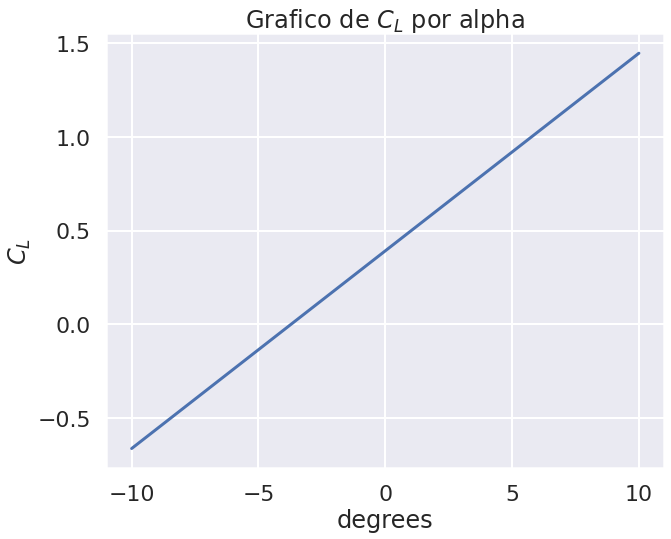

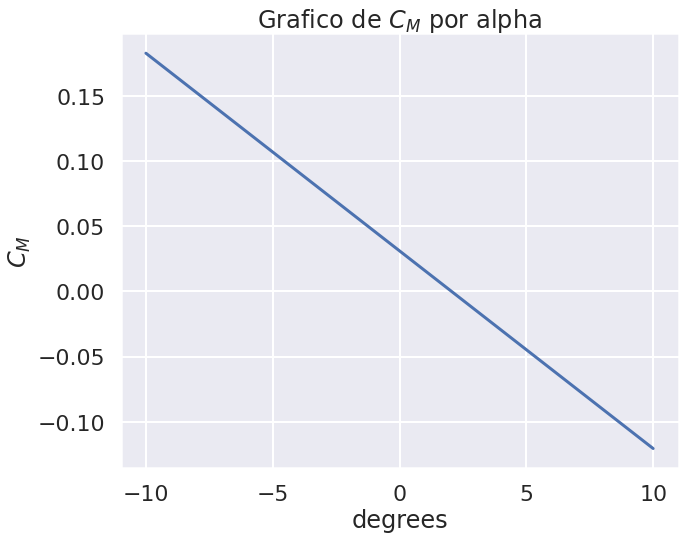

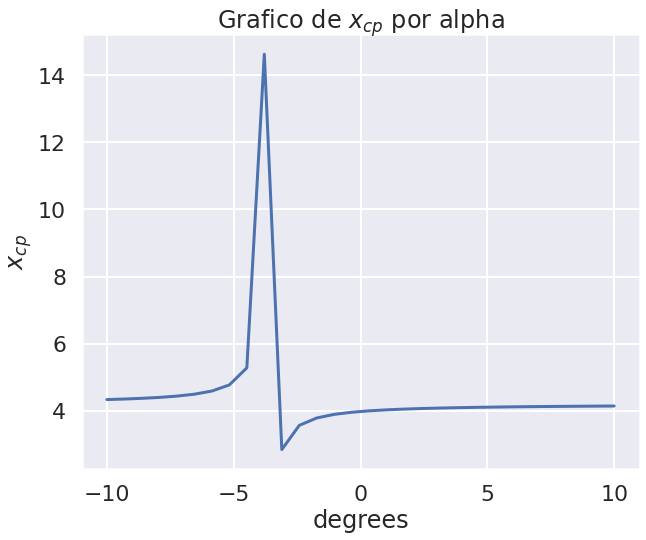

In [ ]:
def plot(x, y, legend):
    fig = plt.figure(figsize = (10, 8))
    ax  = sns.lineplot(x = x * 180 / np.pi , y = y)
    ax.set(xlabel = "degrees", 
           ylabel = legend,
           title  = "Grafico de {} por alpha".format(legend))
    
    plt.show() 

def main():
    aircraft = Aircraft()

    alpha = np.linspace(-10, 10, 30) / 180 * np.pi

    aircraft.compute_CL(alpha)
    aircraft.compute_CM(alpha)
    aircraft.compute_xcp()
    aircraft.compute_cl_trim()
    aircraft.compute_xn()

    plot(alpha, aircraft.CL , "$C_L$")
    plot(alpha, aircraft.CM , "$C_M$")
    plot(alpha, aircraft.xcp, "$x_{cp}$")

sns.set_theme("poster")
main()

    

### archive

In [ ]:
from numpy import *

xw = 7.5
zw = -0.88
alphaw = 1 / 180 * pi
arw = 9.74
sw = 34
alpha0w = -3 / 180 * pi
aw = 5.4
lambdaw = 0.48

M = 0.4
xcg = 7.89
zcg = 0
m = 5400
eta = 0.89
enverg = 0

xt = 13.8
zt = 2.68
alphat = 2 / 180 * pi
art = 6.22
st = 6.48
alpha0t = 0 / 180 * pi
at = 5.1
lambdat = 0.3048

In [ ]:
bw = sqrt(arw * sw)
kh = (1 - (zt - zw) / bw) / (2*(xt - xw) / bw) ** (1/3)
klamdba = (10 - 3*lambdaw) / 7
kar = 1 / arw - 1 / (1 + arw ** 1.7)

dedalpha =  4.44 * (kh * klamdba * kar * cos(0)) ** (1.19)
alpha = (alpha0w - alphaw)
epsilon0 = - dedalpha * alpha

cl_alpha = (aw + at * st / sw * eta * (1 - dedalpha))
cl0 = aw * (alphaw - alpha0w) + at * st/sw * eta * (alphat - epsilon0 - alpha0t)

cr = 2 * sw / bw / (1 + lambdaw)
cma = 2/3 * cr * (1 + lambdaw + lambdaw ** 2) / (1 + lambdaw)

cm_alpha = aw * (xcg - xw) / cma - at * (st / sw) * eta * ((xt - xcg) / cma) * (1 - dedalpha)
cm_0 = aw * (alphaw - alpha0w) * (xcg - xw) / cma - at * (alphat - epsilon0 - alpha0t) * eta * (st / sw) * (xt - xcg) / cma